This is implementation of autoender architecture 

Load libs

In [1]:
from sklearn.model_selection import train_test_split
from file_utils import get_file_names_from_folder
from image_utils import load_images
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Conv2DTranspose
from tensorflow.keras import Model, layers
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
plt.rcParams['figure.figsize'] = [15, 6]

2023-03-29 00:21:47.336755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data

Set params of net and data

In [423]:
INPUT_IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8
EPOTHS = 30

In [338]:
file_names = get_file_names_from_folder('data/SIDD_Small/')
file_names.sort()
gt_images = []
noisy_images = []
for image_path in file_names:
    if image_path.split('/')[-1].startswith('GT'):
        gt_images.append(image_path)
    else:
        noisy_images.append(image_path)
        
file_names = get_file_names_from_folder('data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages',  mask = '*.JPG*')
file_names.sort()
for image_path in file_names:
    if image_path.split('/')[-1].endswith('mean.JPG'):
        gt_images.append(image_path)
    else:
        noisy_images.append(image_path)

gt_images_set = load_images(gt_images, size=INPUT_IMAGE_SIZE)
noisy_images_set = load_images(noisy_images, size=INPUT_IMAGE_SIZE)

In [339]:
gt_images_set.shape

(260, 512, 512, 3)

Split images to train and test sets

In [340]:

gt_train, gt_test, noisy_train, noisy_test = train_test_split(gt_images_set, noisy_images_set, train_size=0.8, shuffle=True)
print(len(gt_train))
print(len(gt_test))
print(len(noisy_train))
print(len(noisy_test))

208
52
208
52


Plot some examples from datasets

65
(512, 512, 3)


(Text(0.5, 1.0, 'Noise image'), (-0.5, 511.5, 511.5, -0.5))

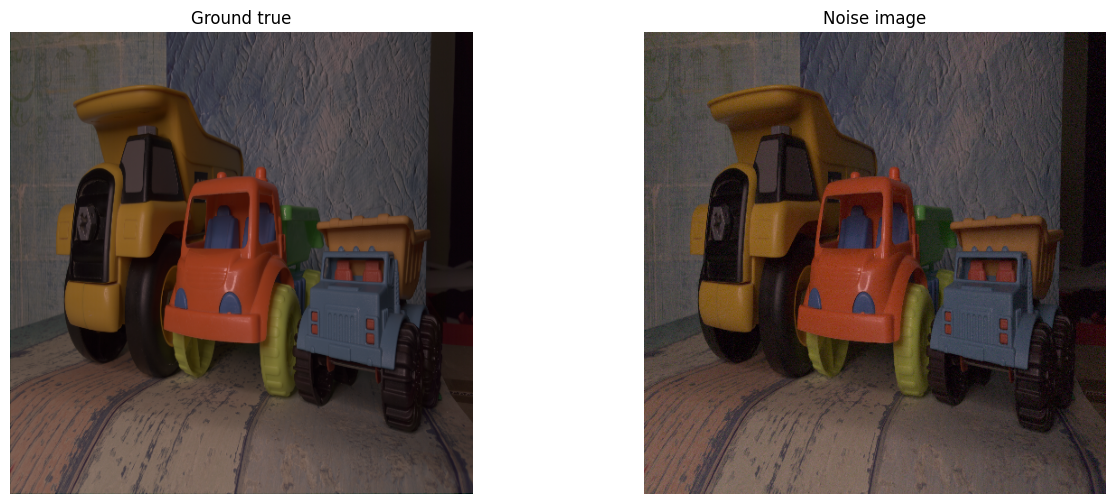

In [350]:
index = np.random.randint(0, len(gt_train))
print(index)
print(gt_train[index].shape)
plt.subplot(1, 2, 1), plt.imshow(gt_train[index])
plt.title('Ground true'), plt.axis(False)
plt.subplot(1, 2, 2), plt.imshow(noisy_train[index])
plt.title('Noise image'), plt.axis(False)

lets calculate PSNR and SSID metrics for ground true and noisy images. This is our key metriccs that we try to increase

In [424]:
def calculate_key_metrics(gt_images, current_images):
    PSNR = 0
    SSID = 0
    for gt_image, noise_image in zip(gt_images, current_images):
        PSNR += psnr(gt_image, noise_image)
        SSID += ssim(gt_image, noise_image, channel_axis=2, data_range=noise_image.max() - noise_image.min())

    PSNR/=gt_images.shape[0]
    SSID/=current_images.shape[0]
    print("Original average PSNR ->", PSNR)
    print("Original average SSIM ->", SSID)
    
calculate_key_metrics(gt_images_set, noisy_images_set)

Original average PSNR -> 31.858143305652174
Original average SSIM -> 0.7056530486894366


apply data generation technics for increasing training set

In [352]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train, y=gt_train, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test, y=gt_test, batch_size=BATCH_SIZE)

Build simple model

In [422]:
def build_model(input_size):
    inputs = x = layers.Input(shape=input_size + (3,))
#    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#    x = layers.Activation("relu")(x)
#    x = layers.BatchNormalization()(x)
    
    u_layers = [x];
    for filter in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filter, 3, padding="same", kernel_initializer='HeNormal')(x)
        x = layers.Conv2D(filter, 3, padding="same", kernel_initializer='HeNormal')(x)
        u_layers.append(x)
#        x = layers.BatchNormalization()(x)

        x = MaxPooling2D((2, 2), padding="same")(x)
        print(x.shape)


    for filter_size in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filter_size, 3, strides=2, padding="same")(x)
#        x = layers.BatchNormalization()(x)

        if (len(u_layers)):
            u_layer = u_layers.pop()
            x = tf.keras.layers.add([u_layer, x])
        
    x = Conv2D(3, kernel_size=(1,1), activation="sigmoid", padding="same")(x)       
    return Model(inputs, x)
        
#encoder
# net = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(input)
# l1 = net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
# net = MaxPooling2D((2, 2), padding="same")(net)
# l2 = net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
# net = MaxPooling2D((2, 2), padding="same")(net)
# l3 = net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
# net = MaxPooling2D((2, 2), padding="same")(net)

# #decoder
# net = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(net)
# net = tf.keras.layers.add([l3, net])
# net = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(net)
# net = tf.keras.layers.add([l2, net])
# net = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(net)
# net = tf.keras.layers.add([l1, net])
# net = Conv2D(3, kernel_size=(1,1), activation="sigmoid", padding="same")(net)

autoencoder = build_model(INPUT_IMAGE_SIZE)
autoencoder.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
autoencoder.summary()

(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 activation_268 (Activation)    (None, 512, 512, 3)  0           ['input_36[0][0]']               
                                                                                                  
 conv2d_262 (Conv2D)            (None, 512, 512, 64  1792        ['activation_268[0][0]']         
                                )                                                                 
        

In [409]:
#plot_model(autoencoder, show_shapes=True)

In [410]:
print(noisy_train.shape, gt_train.shape)
print(noisy_test.shape, gt_test.shape)

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

(208, 512, 512, 3) (208, 512, 512, 3)
(52, 512, 512, 3) (52, 512, 512, 3)


In [425]:
steps_per_epoch_train = len(noisy_train)
steps_per_epoch_validation = len(noisy_test)
#reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=2)
history = autoencoder.fit(
    noisy_train,
    gt_train,
    epochs=EPOTHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    verbose=1,
    validation_data=(noisy_test,gt_test),
)

Epoch 1/30
26/26 [==============================] - 292s 11s/step - loss: 0.0816 - mean_squared_error: 0.0816 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 2/30
26/26 [==============================] - 278s 11s/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 3/30
26/26 [==============================] - 274s 11s/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/30
26/26 [==============================] - 268s 10s/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/30
26/26 [==============================] - 265s 10s/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 6/30
26/26 [==============================] - 262s 10s/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/30
26/26 [==========

Train mse      0.0007531126611866057
Validation mse 0.0006783852004446089


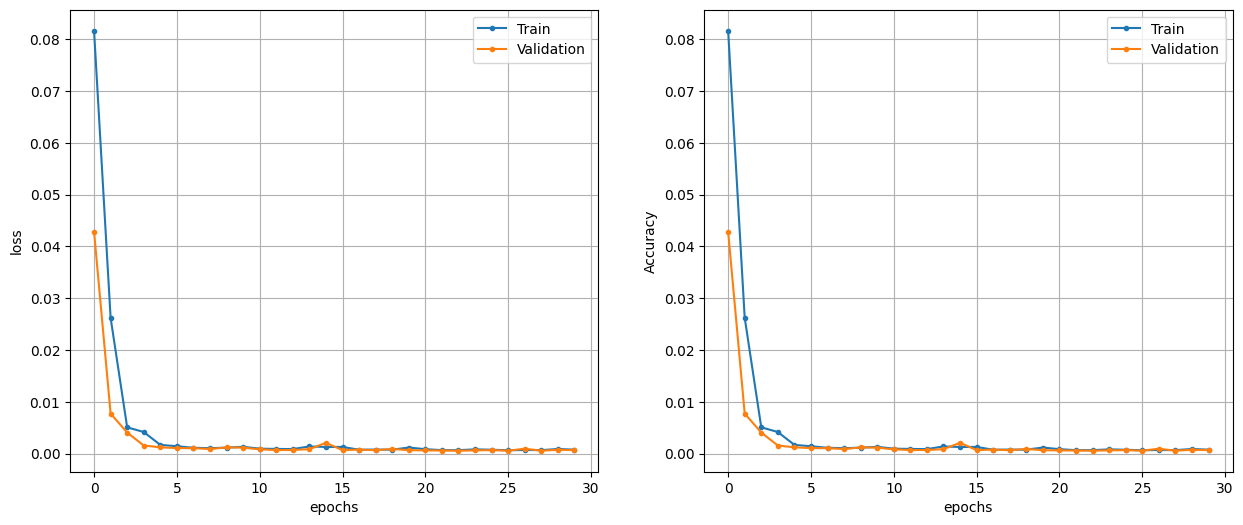

In [426]:
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['mean_squared_error'], '.-',
                           epochs, h['val_mean_squared_error'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train mse     ', h['mean_squared_error'][-1])
print('Validation mse', h['val_mean_squared_error'][-1])

In [427]:
predictions = autoencoder.predict(noisy_test)

2/2 [==============================] - 20s 7s/step


In [428]:
calculate_key_metrics(gt_test, predictions)
calculate_key_metrics(gt_test, noisy_test)

/var/folders/zr/m75tnm4s4p1cj7v9pr8mtrdr0000gn/T/ipykernel_53236/4200771665.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  PSNR += psnr(gt_image, noise_image)


Original average PSNR -> 32.37746040987811
Original average SSIM -> 0.8334419317675914
Original average PSNR -> 32.70408621009681
Original average SSIM -> 0.7515595225428022


29


(Text(0.5, 1.0, 'Ground true'), (-0.5, 511.5, 511.5, -0.5))

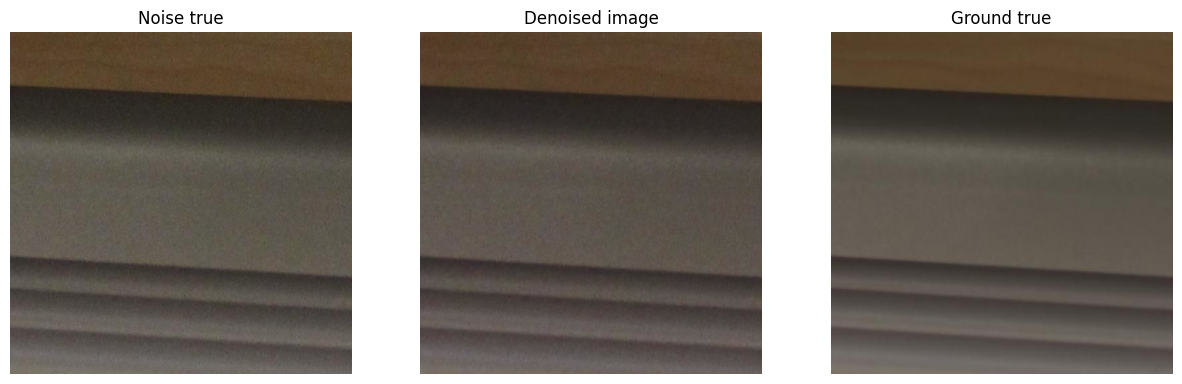

In [438]:
index = np.random.randint(0, len(noisy_test))
print(index)
plt.subplot(1, 3, 1), plt.imshow(noisy_test[index])
plt.title('Noise true'), plt.axis(False)
plt.subplot(1, 3, 2), plt.imshow(predictions[index])
plt.title('Denoised image'), plt.axis(False)
plt.subplot(1, 3, 3), plt.imshow(gt_test[index])
plt.title('Ground true'), plt.axis(False)